In [109]:
import pandas as pd
import dice_ml
import numpy as np

from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import seaborn as sns


## Szukanie "słabych" przypadków

W praktyce pod względem predykcji (klasyfikacji) przypadki dzielą się na następujące grupy:

- Zawsze prawidłowo przewidziane
- Zawsze przewidziane źle (outliers)
- Skaczące (borderlines) - ale jest to kwestia skali

Przyczyną błędów predyckcji w małych zbiorach dla przypadków skaczących danych jest zróżnicowanie rozkładów zmiennych w zbiorze testowym i treningowym. 

- przypadki, zawsze zawyżone albo zaniżone (outliers)
- przypadki zawierające wartości zawyżone lub zaniżone wartość średnia bliska oczekiwanej
- Osobną kwestią jest zakres błędu

![granice_decyzyjne](obrazy/granice_decyzyjne.png)

Istnieje kilka mechanizmów podziału na zbiór treningowy i testowy + modyfikatory, jak grupy czy stratyfikacja na podstawie rozkładu danych.
- `HoldOut` wyznaczania pojedynczego podzbioru (walidacja podzbiorem)
- `LeaveOneOut` - usuwanie ze zbioru uczącego kolejnych pojedynczych przypadków służących za przypadek testowy (walidacja pojedynczym przypadkiem)
- `LeavePOut` -kombinatoryczne usuwanie p przypadków tworzących zbiory testowe. Ze względu na eksplozję kombinatoryczną zastępowany przez `SuffleSplit` (bootstrap)
- `KFold` - usuwanie kolejnych, nienakładających się podzbiorów służących za zbiory testowe

Do wyszukiwania przypadków odstających w praktyce wykorzystuje się `ShuffleSplit`

W Scikit-klearn klasy dzielnące zbiory zwracają indeksy grup a nie zbiory danych, tak jak funkcja pomocnicza `train_test_split()` 

Ocena danych na przykładzie zbiorów diabetes

In [110]:

data = pd.read_csv("Datasets/diabetes_class.csv")
sdata = data.sample(100,random_state=1) # powtarzalność wyników
X = sdata.drop("Class",axis=1)
X = X.reset_index(drop=True)
enc = LabelEncoder().fit(sdata.Class)
y = enc.transform(sdata.Class)

Do wykrycia przypadków skaczączących zastosujemy metody bootstrap (ShuffleSplit) dla 150 powtórzeń oraz LeaveOneOut

In [111]:
n_splits = 150
yhats_ss = np.full((n_splits,y.shape[0]),np.nan) # tworzenie pustej macierzy zawierającej wyniki
ss = ShuffleSplit(n_splits=n_splits, test_size=0.25, random_state=0)
for i, (train_index, test_index) in enumerate(ss.split(X)):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    model = rfc().fit(X_train, y_train)
    yhat = model.predict(X_test)
    yhats_ss[i][test_index] = yhat

#wyniki w sztukach trzeba przeliczyć na wskaźniki procentowe
zeros = (yhats_ss==0).sum(axis=0)
ones = (yhats_ss==1).sum(axis=0)
sums = zeros+ones
zeros_ratio = zeros/sums
ones_ratio = ones/sums
counts = (~np.isnan(yhats_ss)).sum(axis=0)

In [112]:
yhats_prob = np.full(y.shape,np.nan)
loo = LeaveOneOut()
for i, (train_index, test_index) in enumerate(loo.split(X)):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    model = rfc().fit(X_train, y_train)
    yhats_prob[i] = model.predict_proba(X_test)[0][1]

Do oceny przypadków użyjemy wykresu barplot. Przyjmujemy następujące założenia:
* Jeżeli przypadek jest True (1) lub False (0) i ma wartości odpowiednio powyżej 0.9 i poniżej 0.1 są to przypadki odlełge od granicy decyzyjnej
* Jeżeli przypadek jest True (1) lub False (0) i ma wartości odpowiednio  poniżej 0.1 i powyżej 0.9  są to przypadki odstające
* Jeżeli znajdują się pomiędzy 0.3 a 0.7 to są to przypadki graniczne

W przypadku, gdy analizujemy probablilty, mamy do dyspozycji pradwdopodobieństwo zaliczenia do klasy True

(-0.5, 99.5)

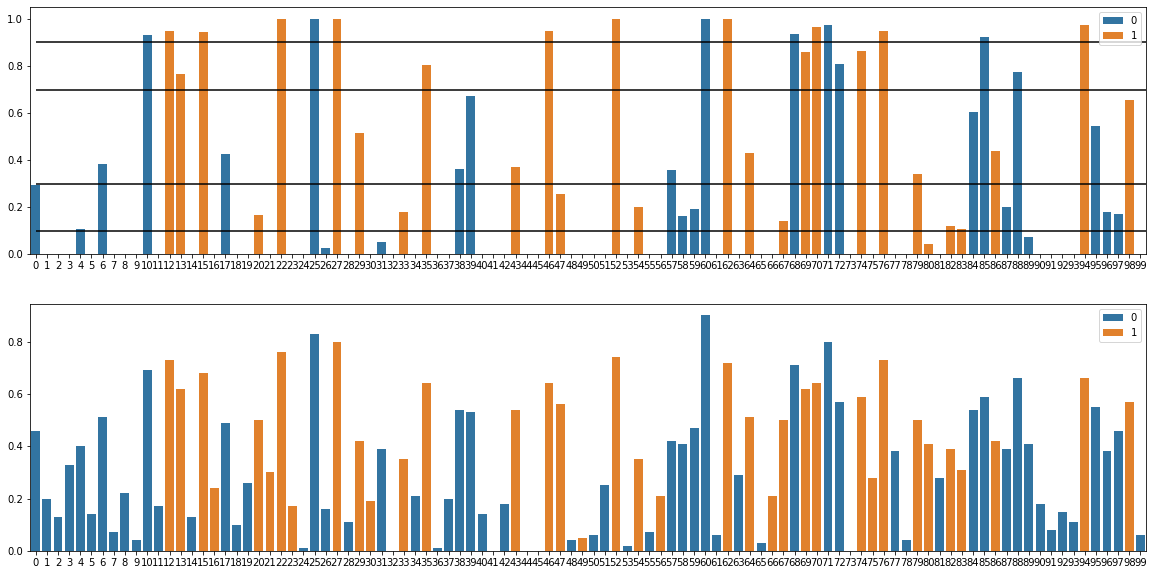

In [113]:
fig,(ax1,ax2) = plt.subplots(nrows=2,figsize=(20,10))
sns.barplot(x=range(100),y=ones_ratio,hue=y,ax=ax1)
ax1.hlines((0.1,0.3,0.7,0.9),0,100,color="k")
ax1.set_xlim(-0.5,99.5)
sns.barplot(x=range(100),y=yhats_prob,hue=y,ax=ax2)
ax2.set_xlim(-0.5,99.5)

## Conterfactual reasoning (wnioskowanie wbrew faktom)
Metoda wnioskowania wbrew faktom polega na generowaniu przypakdów zbliżonych do szukanego i wyboru tych, które dają najbardziej oczekiwane wyniki, tzn. prawidłową klasę, lub niewielki błąd dla regresji.

Pakiet pozwalający na CFR to dice_ml. Wymaga złożonego przygotowania danych.

Przykład dla przypadku, mocno skaczącego. Orginalnie True. Jako zbiór treningowy wykorzystamy cały zbiór, za wyjątkiem wybranego przypadku (LeaveOneOut)

In [114]:
i = 20
print(y[i]," ",ones_ratio[i])


1   0.16666666666666666


In [115]:
test_index = i
X_train = X.drop(axis=0,index=test_index)
y_train = np.delete(y,test_index)
X_test = X.iloc[test_index:test_index+1]

model = rfc().fit(X_train, y_train)
model.predict(X_test) # czy będzie błąd

array([0])

### Zbudowanie explainera

In [116]:
m = dice_ml.Model(model=model, backend="sklearn")
d = dice_ml.Data(dataframe=data,continuous_features=data.columns.to_list()[:-1],outcome_name='Class')
exp = dice_ml.Dice(d, m, method="random")

In [117]:
e = exp.generate_counterfactuals(X_test, total_CFs=2, desired_class="opposite")
e.visualize_as_dataframe()

100%|██████████| 1/1 [00:00<00:00,  6.96it/s]

Query instance (original outcome : 0)


,Number of times pregnant,Plasma glucose concentration,Diastolic blood pressure,Triceps skin fold thickness,2-Hour serum insulin,Body mass index,Diabetes pedigree function,Age,Class
0,4,125,70,18,122,28.9,1.144,45,0



Diverse Counterfactual set (new outcome: 1.0)


,Number of times pregnant,Plasma glucose concentration,Diastolic blood pressure,Triceps skin fold thickness,2-Hour serum insulin,Body mass index,Diabetes pedigree function,Age,Class
0,4.0,125.0,70.0,18.0,122.0,51.9,1.144,45.0,1
1,4.0,125.0,70.0,55.0,122.0,29.0,0.620,45.0,1


W praktyce wydobywanie danych nie jest możliwe przy pomocy dostępnych funkcji. Trzeba sięgnąć do zmiennych ukrytych

In [118]:
e0 = e._cf_examples_list[0]
e0_df = e0.final_cfs_df
e0_df

,Number of times pregnant,Plasma glucose concentration,Diastolic blood pressure,Triceps skin fold thickness,2-Hour serum insulin,Body mass index,Diabetes pedigree function,Age,Class
0,4.0,125.0,70.0,19.0,122.0,51.9,1.144,45.0,1
1,4.0,125.0,70.0,55.0,122.0,28.9,0.620,45.0,1


Wizualizacja zmiennych

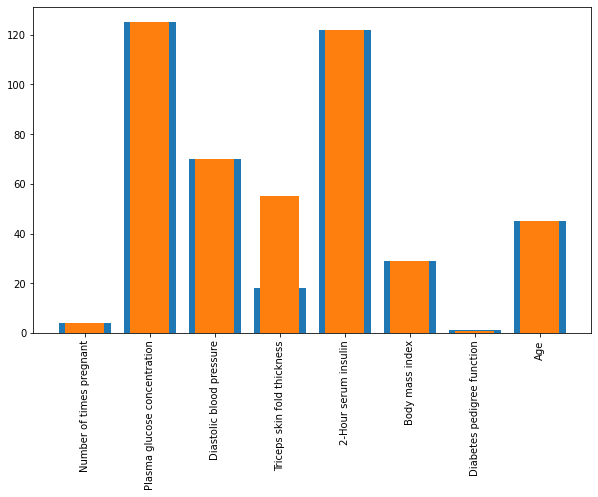

In [119]:
fig,ax = plt.subplots(figsize=(10,6))
ax.bar(x=X_test.columns,height=X_test.iloc[0])
ax.bar(x=X_test.columns,height=e0_df.iloc[1,:-1],width=0.6) # dla drugiego przypadku
ax.tick_params(axis='x', labelrotation = 90)

## Regresja

w przypadku regresji możemy zastosować dwie metody oceny pojedycznych przypadków: LeaveOneOut (jedna wartość) lub bootstrap (z odchyleniem standardowym)

In [120]:
data = pd.read_csv("Datasets/diabetes_reg.csv")
sdata = data.sample(100,random_state=1) # powtarzalność wyników
sdata = sdata.reset_index(drop=True)
X = sdata.drop("progress",axis=1)
y = sdata.progress


Leave one out

In [121]:
loo = LeaveOneOut()
yhats = []
for i, (train_index, test_index) in enumerate(loo.split(X)):
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_test = X.iloc[test_index]
    model = rfr().fit(X_train, y_train) # zmieniamy na regressor
    yhats.append(model.predict(X_test))
yhats_1 = np.array(yhats).flatten()

Bootstrap

In [122]:
n_splits = 150
yhats = np.full((n_splits,y.shape[0]),np.nan)
ss = ShuffleSplit(n_splits=n_splits, test_size=0.25, random_state=0)
for i, (train_index, test_index) in enumerate(ss.split(X)):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    model = rfr().fit(X_train, y_train)
    yhat = model.predict(X_test)
    yhats[i][test_index] = yhat

yhats_2_mean = np.nanmean(yhats,axis=0)
yhats_2_std = np.nanstd(yhats,axis=0)

### Analiza przy pomocy wykresu

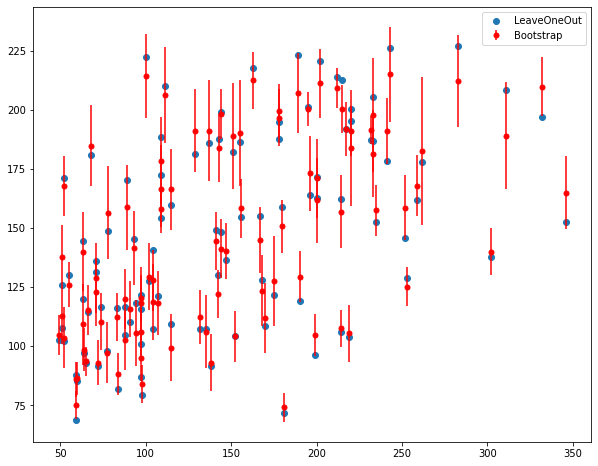

In [123]:
fig,ax = plt.subplots(figsize=(10,8))
ax1 = ax.scatter(y,yhats_1,label="LeaveOneOut")
ax2 = ax.errorbar(y,yhats_2_mean,yhats_2_std,fmt=".r",label="Bootstrap",markersize=10)
_ = ax.legend()

## CFR dla regresji 
wymaga zaznaczenia że jest to model regresyjny oraz wskazać oczekiwany zakres wyniku predykcji. Pozostałe elementy są podobne do wnioskowania dla klasyfikacji. Przykład zostanie przeprowadzony dla przypadku 37

In [124]:
test_index = 37
X_train = X.drop(axis=0,index=test_index)
y_train = np.delete(y.values,test_index)
X_test = X.iloc[test_index:test_index+1]

model = rfr().fit(X_train, y_train)

yhat = model.predict(X_test)
y_test=y.values[test_index]
print(y_test,yhat)

215 [198.78]


In [125]:
m = dice_ml.Model(model=model, backend="sklearn",model_type="regressor")
d = dice_ml.Data(dataframe=data,continuous_features=data.columns.to_list()[:-1],outcome_name='progress')
exp = dice_ml.Dice(d, m, method="random")

In [126]:
e = exp.generate_counterfactuals(X_test, total_CFs=2, desired_range=[250,260])
e.visualize_as_dataframe()

100%|██████████| 1/1 [00:00<00:00,  6.99it/s]

Query instance (original outcome : 199)


,age,sex,bmi,blood preasure,total cholesterol,low-density lipoprotein,high-density lipoproteins,total cholesterol / HDL,serum triglycerides level,glucose,progress
0,45,1,32.0,110.0,224,134.199997,45.0,5.0,5.4116,93,199.0



Diverse Counterfactual set (new outcome: [250, 260])


,age,sex,bmi,blood preasure,total cholesterol,low-density lipoprotein,high-density lipoproteins,total cholesterol / HDL,serum triglycerides level,glucose,progress
0,45.0,1.0,39.9,110.0,166.0,134.2,45.0,5.0,5.2870,93.0,254.440002
1,45.0,1.0,39.9,110.0,166.0,134.2,45.0,5.0,5.4116,93.0,253.020004


In [127]:
e0 = e._cf_examples_list[0]
e0_df = e0.final_cfs_df
e0_df

,age,sex,bmi,blood preasure,total cholesterol,low-density lipoprotein,high-density lipoproteins,total cholesterol / HDL,serum triglycerides level,glucose,progress
0,45.0,1.0,39.9,110.0,166.0,134.2,45.0,5.0,5.2870,93.0,254.0
1,45.0,1.0,39.9,110.0,166.0,134.2,45.0,5.0,5.4116,93.0,253.0


Wizualizacja proponowanych zmian

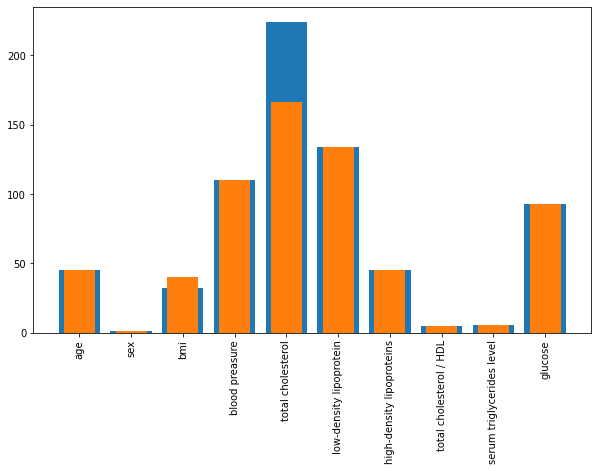

In [128]:
fig,ax = plt.subplots(figsize=(10,6))
ax.bar(x=X_test.columns,height=X_test.iloc[0])
ax.bar(x=X_test.columns,height=e0_df.iloc[1,:-1],width=0.6)
ax.tick_params(axis='x', labelrotation = 90)

## Zadanie: 

> dla zbioru danych "beton" dla wybranych przypadków, wskazać jakie minimalne zmiany musiały by zostać wprowadzone, aby dany beton był mocniejszy. Czy takie postępowanie jest prawidłowe?